## 1: Face Recognition, but not evil this time

Using the faces dataset in:

```
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
```

If you use the `faces.target` and `faces.target_names` attributes, you can build a facial recognition algorithm.

Use sklearn **gridsearch** (or an equivalent, like random search) to optimize the model for accuracy. Try both a SVM-based classifier and a logistic regression based classifier (with a feature pipeline of your choice) to get the best model. You should have at least 80% accuracy.

In [2]:
#SVM Based Classifier

from time import time
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import os
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.pipeline import Pipeline
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

faces = fetch_lfw_people(min_faces_per_person = 175)
faces.data.shape

(766, 2914)

In [3]:
X = faces.data
y = faces.target

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [5]:
n_components = 150

pca = PCA(n_components = n_components, svd_solver = 'randomized',
          whiten = True).fit(X_train)

In [6]:
n_samples, h, w = faces.images.shape

eigenfaces = pca.components_.reshape((n_components, h, w))

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [7]:
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], 
             }
clf = GridSearchCV(SVC(kernel = 'rbf', class_weight = 'balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)

print(clf.best_estimator_)

SVC(C=1000.0, class_weight='balanced', gamma=0.005)


In [8]:
print("Predicting people's names on the test set")

y_pred = clf.predict(X_test_pca)
target_names = faces.target_names
n_classes = target_names.shape[0]

print(classification_report(y_test, y_pred, target_names = target_names))
print(confusion_matrix(y_test, y_pred, labels = range(n_classes))) #not a good accuracy score (68%)

Predicting people's names on the test set
               precision    recall  f1-score   support

 Colin Powell       0.96      0.90      0.93        59
George W Bush       0.96      0.98      0.97       133

     accuracy                           0.96       192
    macro avg       0.96      0.94      0.95       192
 weighted avg       0.96      0.96      0.96       192

[[ 53   6]
 [  2 131]]


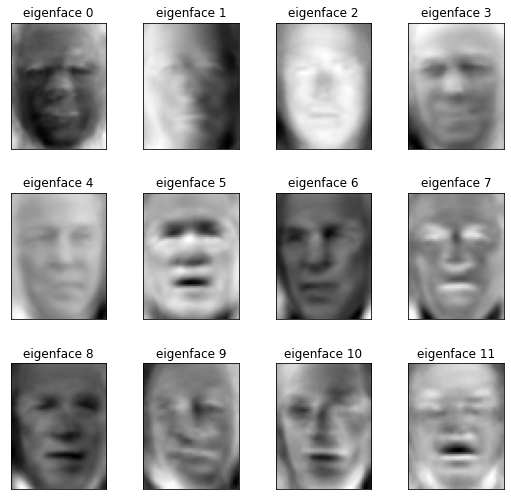

In [9]:
#Cool Add-On from a Kaggle Notebook

def plot_gallery(images, titles, h, w, n_row = 3, n_col = 4):
    plt.figure(figsize = (1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom = 0, left = 0.01, right = 0.99, top = 0.90, hspace = 0.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap = plt.cm.gray)
        plt.title(titles[i], size = 12)
        plt.xticks(())
        plt.yticks(())

eigenfaces = pca.components_.reshape((n_components, h, w))
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()

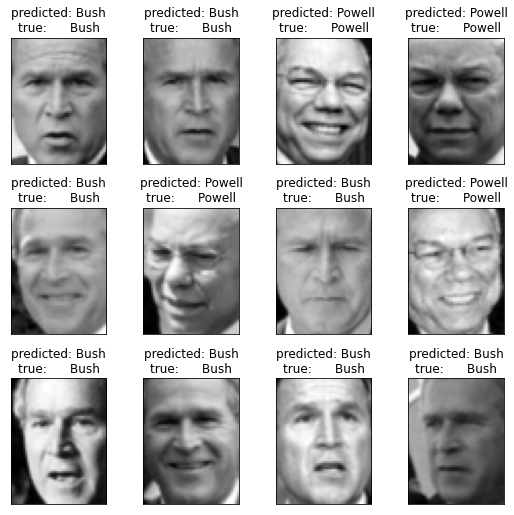

In [10]:
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

In [11]:
#Logistic Regression

logreg_clf = LogisticRegression(random_state = 0)

logreg_clf.fit(X_train_pca, y_train)

LogisticRegression(random_state=0)

In [12]:
y_pred_log = logreg_clf.predict(X_test_pca)

In [13]:
accuracy_score(y_test, y_pred_log)

0.8854166666666666

In [14]:
#Pipeline

pipe = Pipeline([
    ('standard_scaler', StandardScaler()),
    ('pca', PCA()),
    ('reg', LogisticRegression()),
])

pipe.fit(X_train, y_train)

Pipeline(steps=[('standard_scaler', StandardScaler()), ('pca', PCA()),
                ('reg', LogisticRegression())])

In [15]:
pipe.score(X_test, y_test)

0.921875

In [16]:
param_grid = [
    {
    'pca__n_components': np.arange(300, 500, 40),
    'reg__fit_intercept': [True, False],
    'reg__C': [0.1, 2, 2]
}]

In [17]:
grid = GridSearchCV(pipe, param_grid, cv = 4, verbose = 1)
grid.fit(X_train, y_train)
grid.best_params_

model = grid.best_estimator_

Fitting 4 folds for each of 30 candidates, totalling 120 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   19.2s finished


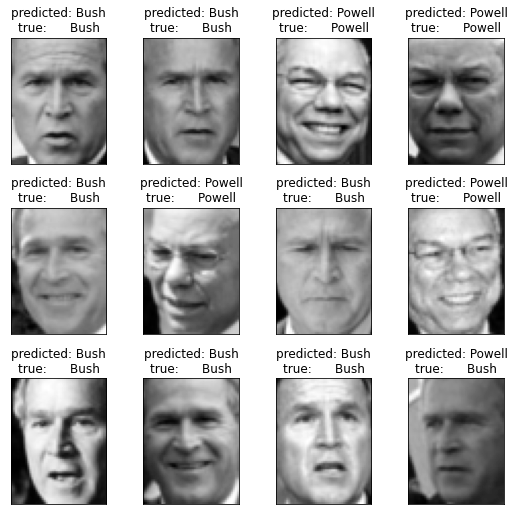

In [18]:
y_pred = model.predict(X_test)

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

In [19]:
accuracy_score(y_test, y_pred)

0.9270833333333334

In [20]:
grid.best_params_

{'pca__n_components': 340, 'reg__C': 0.1, 'reg__fit_intercept': True}

# 2: Bag of Words, Bag of Popcorn

By this point, you are ready for the [Bag of Words, Bag of Popcorn](https://www.kaggle.com/c/word2vec-nlp-tutorial/data) competition. 

Use NLP feature pre-processing (using, SKLearn, Gensim, Spacy or Hugginface) to build the best classifier you can. Use a  feature pipeline, and gridsearch for your final model.

A succesful project should get 90% or more on a **holdout** dataset you kept for yourself.

In [21]:
import pandas as pd
import re
import gensim.downloader as model_api
import numpy as np
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

train = pd.read_csv('Trains.csv', skiprows = 1)
train

,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...
...,...,...,...
24995,3453_3,0,It seems like more consideration has gone into...
24996,5064_1,0,I don't believe they made this film. Completel...
24997,10905_3,0,"Guy is a loser. Can't get girls, needs to buil..."
24998,10194_3,0,This 30 minute documentary Buñuel made in the ...


In [22]:
replaceDict = dict({
'{':" ", '}':" ", ',':"", '.':" ", '!':" ", '\\':" ", '/':" ", '$':" ", '%':" ",
'^':" ", '?':" ", '\'':" ", '"':" ", '(':" ", ')':" ", '*':" ", '+':" ", '-':" ",
'=':" ", ':':" ", ';':" ", ']':" ", '[':" ", '`':" ", '~':" ",
})

rep = dict((re.escape(k), v) for k, v in replaceDict.items())

pattern = re.compile("|".join(rep.keys()))
def replacer(text):
    return rep[re.escape(text.group(0))]

words = train.review.str.replace(pattern, replacer).str.lower().str.split()
words = pd.DataFrame(words.tolist())
words

,0,1,2,3,4,5,6,7,8,9,...,2509,2510,2511,2512,2513,2514,2515,2516,2517,2518
0,with,all,this,stuff,going,down,at,the,moment,with,...,None,None,None,None,None,None,None,None,None,None
1,the,classic,war,of,the,worlds,by,timothy,hines,is,...,None,None,None,None,None,None,None,None,None,None
2,the,film,starts,with,a,manager,nicholas,bell,giving,welcome,...,None,None,None,None,None,None,None,None,None,None
3,it,must,be,assumed,that,those,who,praised,this,film,...,None,None,None,None,None,None,None,None,None,None
4,superbly,trashy,and,wondrously,unpretentious,80,s,exploitation,hooray,the,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,it,seems,like,more,consideration,has,gone,into,the,imdb,...,None,None,None,None,None,None,None,None,None,None
24996,i,don,t,believe,they,made,this,film,completely,unnecessary,...,None,None,None,None,None,None,None,None,None,None
24997,guy,is,a,loser,can,t,get,girls,needs,to,...,None,None,None,None,None,None,None,None,None,None
24998,this,30,minute,documentary,buñuel,made,in,the,early,1930,...,None,None,None,None,None,None,None,None,None,None


In [23]:
#pip install --upgrade gensim

In [24]:
word_vectors = model_api.load("word2vec-google-news-300")

words.columns = words.columns.astype(str)

def soft_get(w):
    try:
        return word_vectors[w]
    except KeyError:
        return np.zeros(word_vectors.vector_size)
    
def map_vectors(row):
    try:
        return np.sum(
            row.loc[row.notna()].apply(soft_get)
        )
    except:
        return np.zeros(word_vectors.vector_size)
    
emb = pd.DataFrame(words.apply(map_vectors, axis=1))
emb.columns = ['C']
emb = pd.DataFrame(np.array(emb.C.apply(pd.Series)))
emb

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,17.283424,11.937847,18.506580,45.120676,-24.435819,3.551744,12.055645,-27.254570,30.983692,19.554092,...,-24.531746,23.092484,-33.328987,9.722412,-26.716827,-10.303997,2.579872,-19.129990,11.317310,-4.080734
1,4.778992,6.744947,3.544289,15.174940,-8.201431,0.314445,4.249725,-9.231554,7.977154,8.119308,...,-12.727188,3.146690,-12.804749,3.808205,-6.146217,-2.835491,-0.495293,-4.693481,4.241936,-0.824364
2,7.668854,18.400442,2.117029,24.500671,-17.646823,-1.491764,3.763025,-24.287819,18.558378,24.320732,...,-23.039650,6.284547,-23.298676,15.287937,-12.791531,-5.257778,2.578659,-12.364639,8.910461,4.143981
3,13.438416,9.676690,3.184448,28.120438,-22.092400,3.097771,14.640491,-28.468567,23.722717,22.710403,...,-25.556366,4.002686,-23.584404,9.610126,-10.111442,-2.726578,3.336586,-10.713562,16.601911,3.251701
4,17.447418,9.209012,8.393372,27.671641,-22.164581,1.606564,11.384158,-23.531187,22.702066,23.904671,...,-24.457840,10.056759,-29.204399,6.255138,-14.498840,-0.895094,6.454372,-19.625992,0.599186,1.965607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,4.843140,3.083902,0.044777,8.552612,-7.245542,1.479004,4.257339,-4.647678,4.680054,2.775642,...,-5.378468,6.225250,-7.275024,3.712402,-4.262329,-1.908768,4.530167,-3.873884,-0.512589,0.154842
24996,5.863220,2.340229,2.210129,12.314983,-7.772020,1.114616,10.503281,-13.057060,13.101852,12.770050,...,-15.988598,6.903183,-15.212250,2.484120,-5.440849,-1.743176,2.057991,-6.311344,6.623047,-2.365334
24997,2.160698,3.789089,-0.081245,13.001617,-8.620522,-1.689472,2.976837,-6.946411,7.065413,7.312721,...,-7.426193,9.140686,-10.666756,4.078735,-6.753197,0.665543,-0.919044,-7.831268,3.209351,-2.725433
24998,9.051056,3.218176,9.683090,16.531189,-7.922881,3.315762,9.002274,-17.094444,12.638168,7.161171,...,-16.743801,0.952118,-15.382585,2.369106,-11.096809,-1.904205,-0.214203,-5.103699,12.709579,-2.317215


In [25]:
emb = emb.fillna(0)

X = Normalizer().fit_transform(emb)
y = train['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.10, random_state = 42)

In [26]:
#RandomForest Score

clf = RandomForestClassifier(n_estimators = 300)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.822

In [27]:
#Pipeline Score

pipe = Pipeline([
    ('standardscaler', StandardScaler()),
    ('pca', PCA()),
    ('reg', LogisticRegression()),
])

pipe.fit(X_train, y_train)

pipe.score(X_test, y_test)

0.8536

In [28]:
#GridSearch Pipeline Score

param_grid = [
    {
    'pca__n_components': np.arange(50, 60, 5),
    'reg__fit_intercept': [True, False],
    'reg__C': [2, 5, 3]
}]

grid = GridSearchCV(pipe, param_grid, cv = 4, verbose = 1)
grid.fit(X_train, y_train)
grid.best_params_

Fitting 4 folds for each of 12 candidates, totalling 48 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:   12.0s finished


{'pca__n_components': 55, 'reg__C': 5, 'reg__fit_intercept': True}

In [29]:
model = grid.best_estimator_

y_pred = model.predict(X_test)

accuracy_score(y_test, y_pred)

0.844

In [30]:
#MLP Classifier Score

clf = MLPClassifier(solver = 'lbfgs', alpha=1e-5,
                     hidden_layer_sizes=(50, 50), random_state=1)

clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.8532